In [2]:
%reset -f

# import Library

In [2]:
import warnings
warnings.filterwarnings('ignore')
SEED = 42
import random
import numpy as np
import tensorflow as tf
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
from matplotlib.pyplot import figure
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller
from tslearn.metrics import dtw
import re
%matplotlib inline
import seaborn as sns
from numpy import argmax
from pylab import rcParams
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from joblib import dump, load
import ast
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.io as pio
from mlxtend.frequent_patterns import association_rules, apriori

2024-09-19 11:41:16.900742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
sersor_files_config = [
    {"name": 'P-PDG', "resample_factor": 1},
    {"name": 'P-TPT', "resample_factor": 1},
    {"name": 'T-TPT', "resample_factor": 1},
    {"name": 'P-MON-CKP', "resample_factor": 1},
    {"name": 'T-JUS-CKP', "resample_factor": 1},
]

EVENTS_MAP = {
    0: {'name': 'Normal', 'n_samples': 0, 'resample_factor': 100},
    1: {'name': 'Abrupt Increase of BSW', 'n_samples': 82000, 'resample_factor': 100},
    2: {'name': 'Spurious Closure of DHSV', 'n_samples': 25000, 'resample_factor': 100},
    3: {'name': 'Severe Slugging', 'n_samples': 60000, 'resample_factor': 100},
    4: {'name': 'Flow Instability', 'n_samples': 7000, 'resample_factor': 100},
    5: {'name': 'Rapid Productivity Loss', 'n_samples': 29000, 'resample_factor': 100},
    6: {'name': 'Quick Restriction in PCK', 'n_samples': 25000, 'resample_factor': 100},
    7: {'name': 'Scaling in PCK', 'n_samples': 0, 'resample_factor': 100},
    8: {'name': 'Hydrate in Production Line', 'n_samples': 25000, 'resample_factor': 100},
  }

# Configure Parameters

In [4]:
# ============================================
# Selection of the class
selected_class = 1
# %store -r selected_class
# Number of clusters
clusters = 2
if selected_class == 1:
    run_grid = True
else:
    run_grid = False
# Windows size
lookback = 10
# =============================================

In [5]:
n_samples = EVENTS_MAP[selected_class]['n_samples']
resample_factor = EVENTS_MAP[selected_class]['resample_factor']
n_resample = int(n_samples/resample_factor)
print(f'Class {selected_class} - ', EVENTS_MAP[selected_class]['name'])

Class 1 -  Abrupt Increase of BSW


In [6]:
PATH_DATASET = f'/home/antonio.azevedo/dataset_new/data/train/'
TEST_DATASET = f'/home/antonio.azevedo/dataset_new/data/test_full/'
print('PATH_DATASET = ', PATH_DATASET)
PATH_SELECTED_FILES = f'/home/antonio.azevedo/3W/toolkit/Machado/results/Selected_Files/Class{selected_class}/'    
PATH_FIGURES = f'/home/antonio.azevedo/3W/toolkit/Machado/results/Figures/Class{selected_class}/'
PATH_CLUSTERS = f'/home/antonio.azevedo/3W/toolkit/Machado/results/Clusters/Class{selected_class}/'
PATH_MODELS = f'/home/antonio.azevedo/3W/toolkit/Machado/results/Models/Class{selected_class}/'
PATH_RESULTS = f'/home/antonio.azevedo/3W/toolkit/Machado/results/Classification_Results/Class{selected_class}/'

PATH_DATASET =  /home/antonio.azevedo/dataset_new/data/train/


In [7]:
global columns
columns = []
for sensor in sersor_files_config:
  columns.append(sensor['name'])

# Split Data

In [11]:
# Split Simulated Instances
from sklearn.model_selection import train_test_split
# print(PATH_DATASET+str(selected_class)+'/SIMULATED*.csv')
trainFiles = glob.glob(PATH_DATASET+str(selected_class)+'/SIMULATED*.csv')
testFiles = glob.glob(TEST_DATASET+str(selected_class)+'/SIMULATED*.csv')
# print(allFiles)
if trainFiles == []:
  print('Not Exists Simulated Files in this class')
  selectedFiles_train_simulated = []
  selectedFiles_valid_simulated = []
  selectedFiles_test_simulated = []
else:
  selectedFiles_train_simulated = trainFiles
  selectedFiles_test_simulated = testFiles
  # selectedFiles_train_simulated, selectedFiles_valid_simulated = train_test_split(selectedFiles_train_simulated, test_size=0.001, random_state=1)
  print('Simulated Training Size: ', len(selectedFiles_train_simulated))
  # print('Simulated Valid Size: ', len(selectedFiles_valid_simulated))
  print('Simulated Test Size: ', len(selectedFiles_test_simulated))

Simulated Training Size:  78
Simulated Test Size:  36


In [15]:
# Split Real Instances
# allFiles = glob.glob(PATH_DATASET+str(selected_class)+'/WELL*.csv')
trainFiles = glob.glob(PATH_DATASET+str(selected_class)+'/WELL*.csv')
testFiles = glob.glob(TEST_DATASET+str(selected_class)+'/WELL*.csv')
if allFiles == []:
  print('Not Exists Real Files in this class')
  selectedFiles_train_real = []
  selectedFiles_valid_real = []
  selectedFiles_test_real = []
else:
    selectedFiles_train_real = trainFiles
    selectedFiles_test_real = testFiles
    # selectedFiles_train_real, selectedFiles_test_real = train_test_split(allFiles, test_size=0.3, random_state=1)
  # selectedFiles_train_real, selectedFiles_valid_real = train_test_split(selectedFiles_train_real, test_size=0.2, random_state=1)
    print('Real Training Size: ', len(selectedFiles_train_real))
  # print('Real Valid Size: ', len(selectedFiles_valid_real))
    print('Real Test Size: ', len(selectedFiles_test_real))

Real Training Size:  3
Real Test Size:  2


In [11]:
# # Split Draw Instances
# allFiles = glob.glob(PATH_DATASET+str(selected_class)+'/DRAW*.csv')
# if allFiles == []:
#   #print('Not Exists Draw Files in this class')
#   selectedFiles_train_draw = []
#   selectedFiles_valid_draw = []
#   selectedFiles_test_draw = []
# else:
#   selectedFiles_train_draw, selectedFiles_test_draw = train_test_split(allFiles, test_size=0.3, random_state=1)
#   selectedFiles_train_draw, selectedFiles_valid_draw = train_test_split(selectedFiles_train_draw, test_size=0.2, random_state=1)
#   #print('Draw Training Size: ', len(selectedFiles_train_draw))
#   #print('Draw Valid Size: ', len(selectedFiles_valid_draw))
#   #print('Draw Test Size: ', len(selectedFiles_test_draw))

In [18]:
# Training Instances
selectedFiles_train = []
if selectedFiles_train_real:
  for re in selectedFiles_train_real:
    selectedFiles_train.append(re)
if selectedFiles_train_simulated:
  for si in selectedFiles_train_simulated:
    selectedFiles_train.append(si)
# if selectedFiles_train_draw:
#   for dr in selectedFiles_train_draw:
#     selectedFiles_train.append(dr)

print('Training Files: ', len(selectedFiles_train))

# Valid Instances
# selectedFiles_valid = []
# if selectedFiles_valid_real:
#   for rev in selectedFiles_valid_real:
#     selectedFiles_valid.append(rev)
# if selectedFiles_valid_simulated:
#   for siv in selectedFiles_valid_simulated:
#     selectedFiles_valid.append(siv)
# if selectedFiles_valid_draw:
#   for drv in selectedFiles_valid_draw:
#     selectedFiles_valid.append(drv)
# positive_selectedFiles_valid = selectedFiles_valid
# print('Positive Valid Files: ', len(positive_selectedFiles_valid))

# Test Instances
selectedFiles_test = []
if selectedFiles_test_real:
  for ret in selectedFiles_test_real:
    selectedFiles_test.append(ret)
if selectedFiles_test_simulated:
  for sit in selectedFiles_test_simulated:
    selectedFiles_test.append(sit)
# if selectedFiles_test_draw:
#   for drt in selectedFiles_test_draw:
#     selectedFiles_test.append(drt)
positive_selectedFiles_test = selectedFiles_test
print('Positive Test Files: ', len(positive_selectedFiles_test))

Training Files:  81
Positive Test Files:  38


In [20]:
# Valid and Test Instances - Negative classes
quantity_negative_files = 4
n_classes = 9
# negative_selectedFiles_valid = []
negative_selectedFiles_test = []
negative_classes = list(range(0,selected_class)) + list(range(selected_class+1, n_classes))
for negative_class in negative_classes:
  negative_files = glob.glob(PATH_DATASET+str(negative_class)+'/*.csv')
  random.Random(SEED).shuffle(negative_files)
  selectedFiles_test_0 = negative_files[0:quantity_negative_files]  
  # selectedFiles_valid_0, selectedFiles_test_0 = train_test_split(negative_files[0:quantity_negative_files], test_size=0.5, random_state=1)
  # negative_selectedFiles_valid = negative_selectedFiles_valid + selectedFiles_valid_0
  negative_selectedFiles_test = negative_selectedFiles_test + selectedFiles_test_0
# print(negative_selectedFiles_valid)
print(negative_selectedFiles_test)

['/home/antonio.azevedo/dataset_new/data/train/0/WELL-00003_20170915220000.csv', '/home/antonio.azevedo/dataset_new/data/train/0/WELL-00001_20170218210311.csv', '/home/antonio.azevedo/dataset_new/data/train/0/WELL-00005_20170402130029.csv', '/home/antonio.azevedo/dataset_new/data/train/0/WELL-00002_20170406000000.csv', '/home/antonio.azevedo/dataset_new/data/train/2/SIMULATED_00012.csv', '/home/antonio.azevedo/dataset_new/data/train/2/SIMULATED_00006.csv', '/home/antonio.azevedo/dataset_new/data/train/2/WELL-00012_20170320143144.csv', '/home/antonio.azevedo/dataset_new/data/train/2/WELL-00011_20140606230115.csv', '/home/antonio.azevedo/dataset_new/data/train/3/WELL-00014_20171028080000.csv', '/home/antonio.azevedo/dataset_new/data/train/3/SIMULATED_00069.csv', '/home/antonio.azevedo/dataset_new/data/train/3/SIMULATED_00040.csv', '/home/antonio.azevedo/dataset_new/data/train/3/WELL-00014_20170925210042.csv', '/home/antonio.azevedo/dataset_new/data/train/4/WELL-00001_20170421180000.csv',

In [21]:
# selectedFiles_valid = positive_selectedFiles_valid + negative_selectedFiles_valid
selectedFiles_test = positive_selectedFiles_test + negative_selectedFiles_test
print('Training Size: ', len(selectedFiles_train))
# print('Valid Size: ', len(positive_selectedFiles_valid), len(negative_selectedFiles_valid))
print('Test Size: ', len(positive_selectedFiles_test), len(negative_selectedFiles_test))

Training Size:  81
Test Size:  38 28


In [15]:
# Save Valid Files
np.save(PATH_SELECTED_FILES+'selectedFiles_valid.npy',selectedFiles_valid)
# Save Test Files
np.save(PATH_SELECTED_FILES+'selectedFiles_test.npy',selectedFiles_test)

# PreProcessing Data

In [22]:
# Verify nan and frozen values
def check_nan_frozen(df):
  df_variable = df
  perc_nan = 0
  perc_max_unique = 0
  df_check_nan = df_variable.isna()
  count_value = df_check_nan[df_check_nan==False].count()
  count_nan = df_check_nan[df_check_nan==True].count()
  if count_value == 0:
    perc_nan = 1
    perc_max_unique = 1
  else:
    perc_nan = count_nan/count_value
    max_unique_values = df_variable.value_counts().max()
    # print('--------------------------')
    # print(df_variable.value_counts())
    # print('--------------------------')
    total_variable_count = df_variable.count()
    perc_max_unique = max_unique_values/total_variable_count
  # print('% NAN ',perc_nan,'% Congelado ', perc_max_unique)
  return  perc_nan, perc_max_unique

In [23]:
def prepared_data(selectedFiles_train, variable_to_analyze):
  global file_index_selected

  files = selectedFiles_train

  dfClass = pd.DataFrame()
  cont = 0
  X=[]
  file_index = 0
  file_index_selected = []
  perc_nan_list = []
  for f in files:
    df = pd.read_csv(f, sep=',', header=0)
    df['class'] = df['class'].replace([selected_class,selected_class+100],1)
    input_y = df['class'].values
    df = df[[variable_to_analyze]]
    perc_nan, perc_max_unique = check_nan_frozen(df[df.columns[0]])
    perc_nan_list.append(perc_nan)
    print(f'\r{cont}/ {len(files)} - % NAN:{perc_nan},% Congelado: {perc_max_unique}', end='')
    if perc_nan < 0.2 and perc_max_unique < 0.95:
      df.interpolate(method = 'linear', limit_direction='both', axis=0, inplace = True)
      input_X = df.values
      input_X_y1 = input_X[input_y==1]
      file_index_selected.append(file_index)
      if len(input_X_y1)<n_samples:
        diff_size = n_samples-len(input_X_y1)
        a = np.arange(1).astype(float)
        a = np.array([np.nan])
        for i in range(diff_size-1):
          a = np.vstack((a, np.array([np.nan])))
        input_X_y1 = np.vstack((input_X_y1,a))
      X_aux = np.array([input_X_y1[0:n_samples]])
      if cont == 0:
          X = X_aux
      else:
        X = np.vstack((X, X_aux))
      cont = cont+1
    file_index = file_index + 1
  X_train = X
  print('\nVariable Analyzed: ', df.columns[0])
  print('n_instances, samples, n_variables')
  print(X_train.shape)
  print(file_index_selected)
  print(perc_nan_list)
  return X_train

# DTW

In [24]:
# import numpy as np
def silhouette_analysis(X_train, max_k):
    scores = []
    X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
    print(X_train.shape[1])
    X_train = TimeSeriesResampler(sz=n_resample).fit_transform(X_train)
    sz = X_train.shape[1]
    print("DBA k-means")
    for k in range(2, max_k + 1):  # Silhouette score is not defined for k=1
        kmeans = TimeSeriesKMeans(n_clusters=k, n_init=2, metric="dtw", verbose=False, max_iter_barycenter=10, random_state=0).fit(X_train)
        labels = kmeans.labels_
        score = silhouette_score(X_train, labels, metric="dtw")
        scores.append(score)
        print('Para n_clusters = ', k, 'Silhouete score =', score)
    # kmeans = TimeSeriesKMeans(n_clusters=clusters, n_init=2, metric="dtw", verbose=False, max_iter_barycenter=10, random_state=0).fit(X_train)
    # labels = kmeans.labels_
    # score = silhouette_score(X_train, labels, metric="dtw")
    # scores.append(score)
    plt.plot(range(2, max_k + 1), scores, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('Medida de Silhueta')
    plt.title('Análise de silhueta')
    plt.show()
    # print('Silhouete score =', score)

78/ 81 - % NAN:0.0,% Congelado: 0.00042793274699039403
Variable Analyzed:  P-PDG
n_instances, samples, n_variables
(79, 82000, 1)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
82000
DBA k-means
Para n_clusters =  2 Silhouete score = 0.4511026364561914
Para n_clusters =  3 Silhouete score = 0.5261003350779161
Para n_clusters =  4 

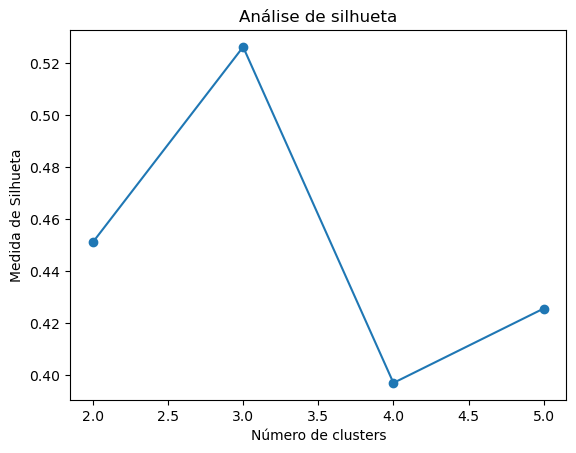

80/ 81 - % NAN:0.0,% Congelado: 0.00043919413506908863
Variable Analyzed:  P-TPT
n_instances, samples, n_variables
(81, 82000, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
82000
DBA k-means
Para n_clusters =  2 Silhouete score = 0.7044836582735235
Para n_clusters =  3 Silhouete score = 0.4592200806093759
Para n_clusters

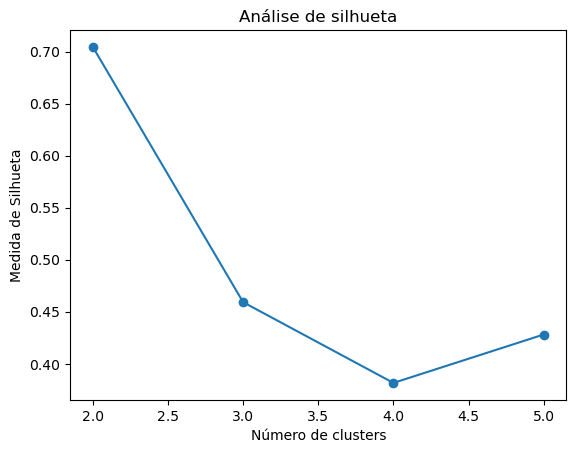

80/ 81 - % NAN:0.0,% Congelado: 0.00061937634432820185
Variable Analyzed:  T-TPT
n_instances, samples, n_variables
(81, 82000, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
82000
DBA k-means
Para n_clusters =  2 Silhouete score = 0.8965706084080445
Para n_clusters =  3 Silhouete score = 0.6509406017773703
Para n_clusters

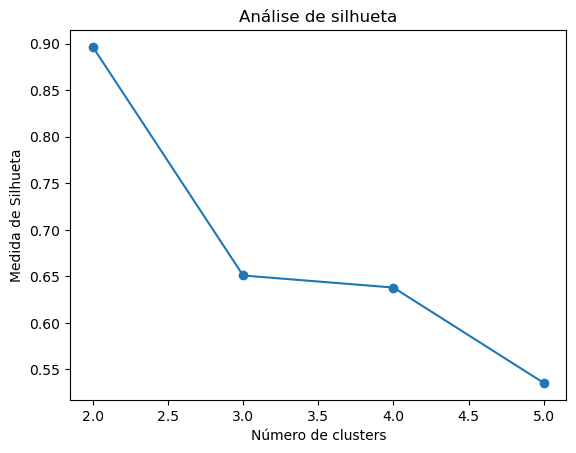

80/ 81 - % NAN:0.0,% Congelado: 0.0152591808466311564
Variable Analyzed:  P-MON-CKP
n_instances, samples, n_variables
(81, 82000, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
82000
DBA k-means
Para n_clusters =  2 Silhouete score = 0.6914303268088057
Para n_clusters =  3 Silhouete score = 0.30985956350450017
Para n_clus

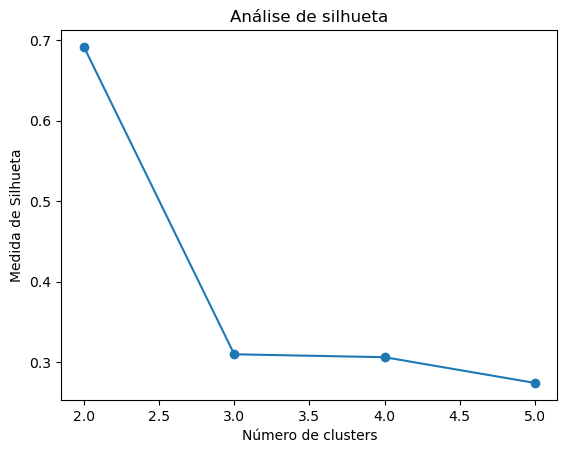

79/ 81 - % NAN:0.0,% Congelado: 0.00064189912048559143
Variable Analyzed:  T-JUS-CKP
n_instances, samples, n_variables
(80, 82000, 1)
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
82000
DBA k-means
Para n_clusters =  2 Silhouete score = 0.8374522862437533
Para n_clusters =  3 Silhouete score = 0.6487228490787414
Para n_cluster

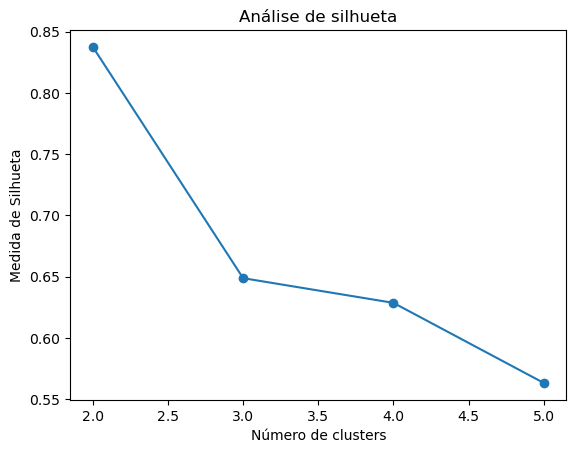

In [25]:
# Evaluating the performance of time series clustering
# similarity = []
for variable_to_analyze in columns:
  X_train  = prepared_data(selectedFiles_train, variable_to_analyze)
  silhouette_analysis(X_train, max_k=5)
  # cluster_instances_index, file_index_selected, similarity_variable = silhouette_analysis(X_train, max_k=10)
  # similarity.append(similarity_variable)

In [26]:
def DTW_timeserie(X_train):
  figure(figsize=(10, 8), dpi=100)
  X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
  print(X_train.shape[1])
  X_train = TimeSeriesResampler(sz=n_resample).fit_transform(X_train)
  sz = X_train.shape[1]
  print("DBA k-means")
  dba_km = TimeSeriesKMeans(n_clusters=clusters,
                            n_init=2,
                            metric="dtw",
                            verbose=False,
                            max_iter_barycenter=10,
                            random_state=0)
  y_pred = dba_km.fit_predict(X_train)
  cluster_instances_index = {}
  distance_cluster = {}
  similarity_variable = {}
  for yi in range(clusters):
      distance_instances = []
      cluster_instances_index_selected = []
      cluster_instances_index[yi+1] = np.squeeze(np.where(y_pred == yi))
      cont = 0
      # if only one instance in one cluster
      if cluster_instances_index[yi+1].size==1:
        cluster_instances_index_selected.append(file_index_selected[cluster_instances_index[yi+1]])
        distance_pair = 0
        distance_instances.append(distance_pair)
      else:
        for k in cluster_instances_index[yi+1]:
          cluster_instances_index_selected.append(file_index_selected[k])
          distance_pair = dtw(dba_km.cluster_centers_[yi].ravel(), np.squeeze(X_train[k]))
          distance_instances.append(distance_pair)
      distance_cluster[yi+1] = distance_instances
      print('Mean Distance Cluster ', yi+1, ': ', np.mean(distance_cluster[yi+1]))
      similarity_variable[yi+1] = np.mean(distance_cluster[yi+1])
      similarity_variable['variable_name'] = variable_to_analyze
      cluster_instances_index[yi+1] = cluster_instances_index_selected
      print('instances cluster', yi+1, np.where(y_pred == yi))
      plt.subplot(clusters, clusters, 1 + yi)
      for xx in X_train[y_pred == yi]:
          plt.plot(xx.ravel(), "k-", alpha=.2)
          cont = cont+1
      plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
      plt.grid()
      plt.xlim(0, sz)
      plt.ylabel('Ajustado')
      plt.xlabel('Tempo (s)')
      plt.ylim(-4, 4)
      plt.text(0.5, 0.8,'Total de instâncias: %d' % (cont),
              transform=plt.gca().transAxes)
      plt.title('Cluster %d' % (yi + 1) +' - '+ variable_to_analyze)
  plt.tight_layout()
  if clusters == 1:
    plt.savefig(f'{PATH_FIGURES}{variable_to_analyze}_geral.png', dpi=300)
  else:
    plt.savefig(f'{PATH_FIGURES}{variable_to_analyze}.png', dpi=300)
  plt.show()
  print(f"{variable_to_analyze}:", cluster_instances_index)
  return cluster_instances_index, file_index_selected, similarity_variable


78/ 81 - % NAN:0.0,% Congelado: 0.00042793274699039403
Variable Analyzed:  P-PDG
n_instances, samples, n_variables
(79, 82000, 1)
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
82000
DBA k-means
Mean Distance Cluster  1 :  4.53015512828008
instances cluster 1 (array([ 0,  1,  2, 14, 20, 21, 22, 34, 41, 45, 67]),)
Mean Distance Clu

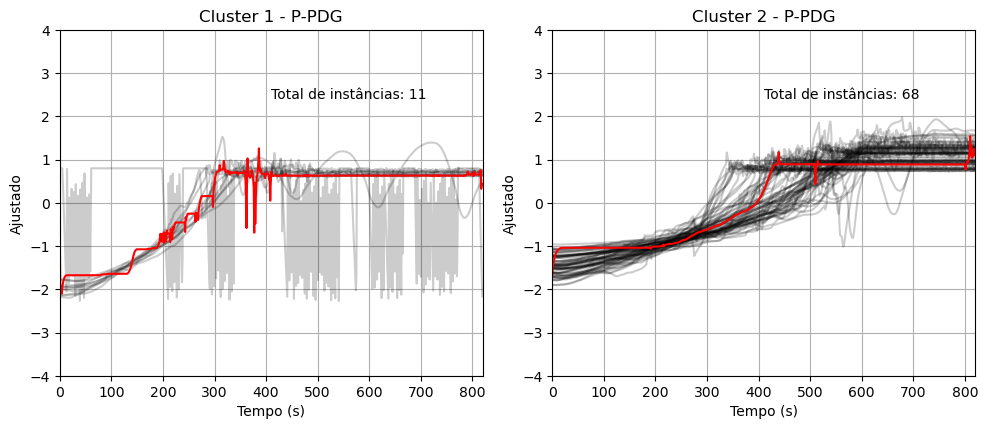

P-PDG: {1: [2, 3, 4, 16, 22, 23, 24, 36, 43, 47, 69], 2: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]}
Saved Clusters Index:  P-PDG.npy
80/ 81 - % NAN:0.0,% Congelado: 0.00043919413506908863
Variable Analyzed:  P-TPT
n_instances, samples, n_variables
(81, 82000, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

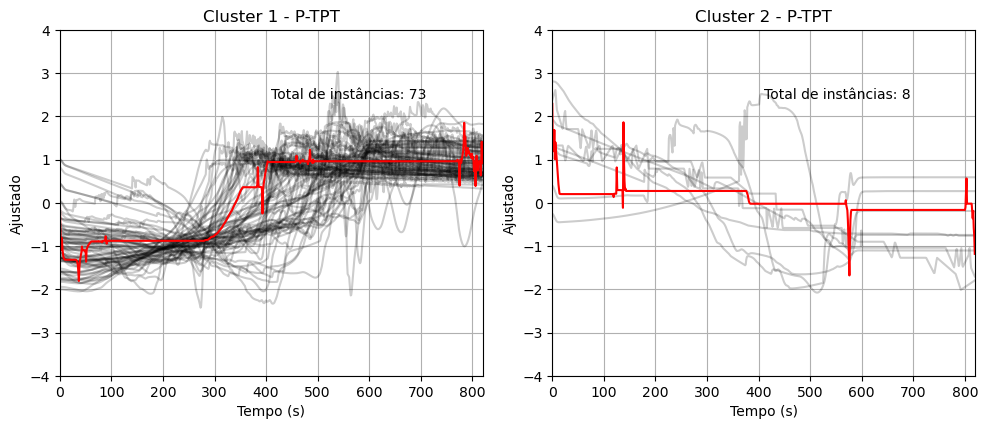

P-TPT: {1: [3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], 2: [0, 1, 2, 8, 9, 10, 20, 41]}
Saved Clusters Index:  P-TPT.npy
80/ 81 - % NAN:0.0,% Congelado: 0.00061937634432820185
Variable Analyzed:  T-TPT
n_instances, samples, n_variables
(81, 82000, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

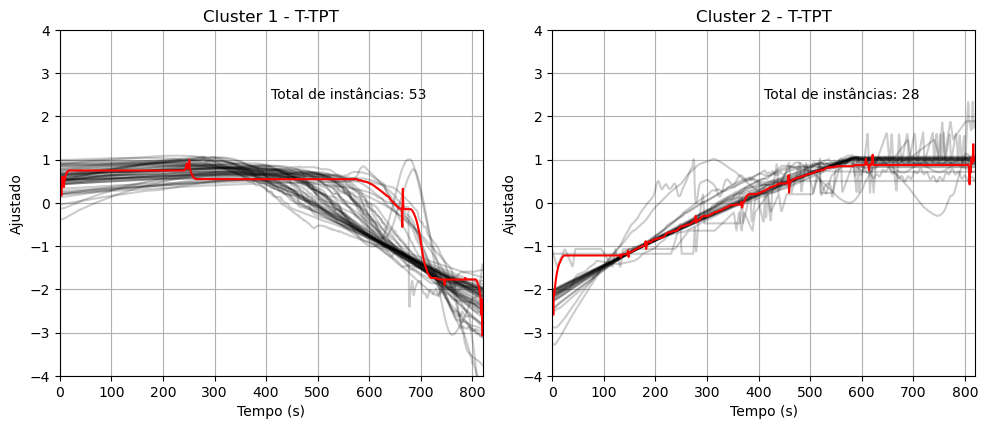

T-TPT: {1: [3, 4, 5, 6, 12, 14, 15, 16, 17, 18, 19, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 37, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 79, 80], 2: [0, 1, 2, 7, 8, 9, 10, 11, 13, 20, 21, 22, 26, 27, 35, 36, 38, 39, 40, 41, 46, 50, 54, 55, 64, 75, 77, 78]}
Saved Clusters Index:  T-TPT.npy
80/ 81 - % NAN:0.0,% Congelado: 0.0152591808466311564
Variable Analyzed:  P-MON-CKP
n_instances, samples, n_variables
(81, 82000, 1)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

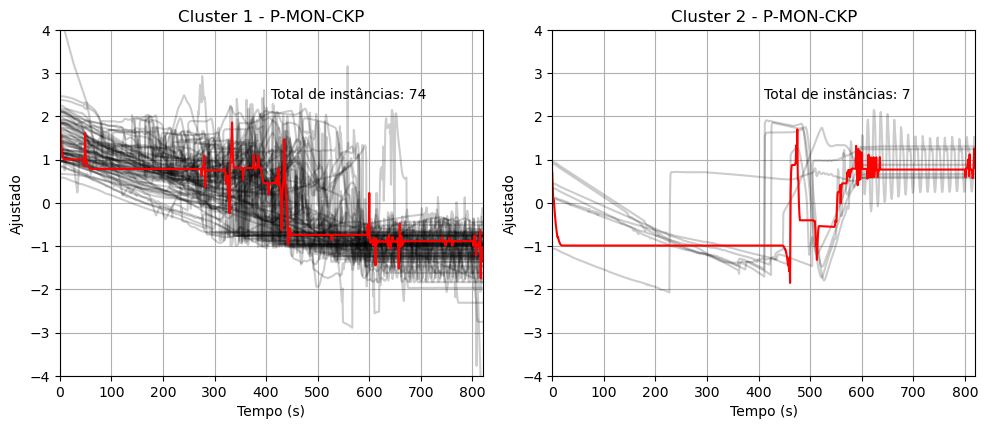

P-MON-CKP: {1: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80], 2: [7, 11, 27, 38, 40, 41, 55]}
Saved Clusters Index:  P-MON-CKP.npy
79/ 81 - % NAN:0.0,% Congelado: 0.00064189912048559143
Variable Analyzed:  T-JUS-CKP
n_instances, samples, n_variables
(80, 82000, 1)
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
similarity = []
for variable_to_analyze in columns:
  X_train  = prepared_data(selectedFiles_train, variable_to_analyze)
  cluster_instances_index, file_index_selected, similarity_variable = DTW_timeserie(X_train)
  similarity.append(similarity_variable)
  # Save clusters instances index
  if clusters == 1:
    geral_instances_index = {1:file_index_selected}
    np.save(f'{PATH_CLUSTERS}Geral_{variable_to_analyze}.npy', geral_instances_index)
    print('Saved Clusters Index: ',f"geral_{variable_to_analyze}.npy")
    np.save(f'{PATH_CLUSTERS}similarity_geral.npy', similarity)
  else:
    np.save(f'{PATH_CLUSTERS}Clusters_{variable_to_analyze}.npy', cluster_instances_index)
    print('Saved Clusters Index: ',f"{variable_to_analyze}.npy")
    np.save(f'{PATH_CLUSTERS}similarity_clusters.npy', similarity)

# Load clusters

In [ ]:
# Create zero Matrix
N_rows = len(selectedFiles_train)
N_cols = len(columns)
for i in range(1,clusters+1):
  globals()["df_matrix_cluster_"+f"{i}"] = pd.DataFrame(np.zeros((N_rows, N_cols)), columns=columns)
# Load clusters Instances Index
contf = 0
if clusters == 1:
  files_DTW_index = glob.glob(f'{PATH_CLUSTERS}Geral_*.npy')
else:
  files_DTW_index = glob.glob(f'{PATH_CLUSTERS}Clusters_*.npy')
for f in files_DTW_index:
  file_name_aux = files_DTW_index[contf].split('/')[-1]
  file_name = file_name_aux.split('.')[0]
  globals()[f"{file_name}"] = np.load(f, allow_pickle=True)
  # print(file_name, globals()[f"{file_name}"].item())
  print(file_name, globals()[f"{file_name}"])
  if clusters == 1:
    globals()["df_matrix_cluster_1"].loc[globals()[f"{file_name}"].item()[1], file_name.split('_')[1]] = 1
  else:
    for c in range(1,clusters+1):
      globals()["df_matrix_cluster_"+f"{c}"].loc[globals()[f"{file_name}"].item()[c], file_name.split('_')[1]] = 1
  contf = contf+1

In [ ]:
# Save binary matrix to cvs's Files
df_matrix_cluster_1.to_csv(f'{PATH_CLUSTERS}matrix_geral.csv')

# Generate Subsets

In [ ]:
#Apriori - Create Subsets
warnings.filterwarnings('ignore')
support_1 = 0.70
frequent_items_C1 = apriori(df_matrix_cluster_1, min_support = support_1, use_colnames = False)
print(frequent_items_C1)

In [ ]:
frequent_items_C1 = frequent_items_C1.iloc[-1:]
frequent_items_C1.reset_index(drop=True, inplace=True)
aux = [list(x) for x in frequent_items_C1.itemsets]
itemsets_cluster1 = [(str(x)) for x in aux]

## Save Subsets

In [ ]:
def saveSelectedVariables(selected_variables):
  selected_variables = [x for x in selected_variables]
  # Save Variables
  np.save(f'{PATH_MODELS}selected_variables.npy',selected_variables)
  print('Save', 'selected_variables.npy', selected_variables )

In [ ]:
def selectInstances(cluster, selected_Variables):
  clusters_selected = []
  if cluster == 0:
    variables = {}
    for col in range(0, len(columns)):
      variables[col] = globals()[f"Geral_{columns[col]}"].item().get(1)
  else:
    variables = {}
    for col in range(0, len(columns)):
      variables[col] = globals()[f"Clusters_{columns[col]}"].item().get(cluster)
  for i in selected_Variables:
          clusters_selected.append(variables[i])
          intersection = set.intersection(*map(set,clusters_selected))
  selectedFiles = {}
  cont_files = 0
  for fs in list(intersection):
    selectedFiles[cont_files] = selectedFiles_train[fs]
    cont_files += 1
  return selectedFiles

In [ ]:
# Dict to Array
def selectedFilesDict2List(selectedFiles_Cluster):
  grupo = []
  for i in range(len(selectedFiles_Cluster.items())):
    grupo.append(selectedFiles_Cluster[i])
  selectedFiles_Cluster = grupo
  return selectedFiles_Cluster

## Calculate subsets similarity

In [ ]:
# Calculate subsets similarity
similarity = np.load(f'{PATH_CLUSTERS}similarity_geral.npy', allow_pickle=True)
# cluster 0
similarity_subset = []
similarity_cluster_0=[]
for subset in range(len(frequent_items_C1['itemsets'])):
    for index_variable in frequent_items_C1['itemsets'][subset]:
      # print(index_variable)
      similarity_variable = [x[1] for x in similarity if x['variable_name']==columns[index_variable]]
      similarity_subset.append(similarity_variable)
similarity_cluster_0.append(np.mean(similarity_subset))


## Create a clusters dataframe with all subsets

In [ ]:

data_cluster_0={
  "Support": frequent_items_C1['support'],
  "Variables": frequent_items_C1['itemsets'],
  "Similarity":similarity_cluster_0,
  "Train_Instances": None,
  "Models": None,
  "TH": None,
  "F1_score": None,
  "Specificity": None,
  "IIP": None,
  "MU": None
  }


In [ ]:
# Create a clusters dataframe with all subsets
df_cluster_0_apriori = pd.DataFrame(data_cluster_0)
cont_subsets_c0 = 0
for subset_c0 in frequent_items_C1['itemsets']:
    selectedFiles_Cluster0 = selectInstances(0,subset_c0)
    selectedFiles_Cluster0 = selectedFilesDict2List(selectedFiles_Cluster0)
    df_cluster_0_apriori.at[cont_subsets_c0,'Train_Instances'] = selectedFiles_Cluster0
    cont_subsets_c0 += 1

# Save Subsets Apriori

In [ ]:
#Save subsets Apriori
if clusters == 1 :
  df_cluster_0_apriori.to_csv(f'{PATH_SELECTED_FILES}df_cluster_0_apriori.csv', sep=',')
else:
  df_cluster_1_apriori.to_csv(f'{PATH_SELECTED_FILES}df_cluster_1_apriori.csv', sep=',')
  df_cluster_2_apriori.to_csv(f'{PATH_SELECTED_FILES}df_cluster_2_apriori.csv', sep=',')

# Functions for Training and test Subsets

In [ ]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback+1):
        t = []
        for j in range(0,lookback):
            # Gather past records upto the lookback period
            t.append(X[[(i+j)], :])
        output_X.append(t)
        output_y.append(y[i+lookback-1])
    if X.shape[1]==1:
      outputAux = np.array(output_X)
      output_X = outputAux.reshape(outputAux.shape[0], outputAux.shape[1], outputAux.shape[2])
      return output_X, np.array(output_y)
    else:
      return np.squeeze(np.array(output_X)), np.array(output_y)

In [ ]:
def flatten(X):
    '''
    Flatten a 3D array.

    Input
    A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

In [ ]:
def scale(X, scaler):
    '''
    Scale 3D array.

    Inputs
    X            A 3D array for lstm, where the array is sample x timesteps x features.
    scaler       A scaler object

    Output
    X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])


    return X

In [ ]:
def trainModel(cluster, subset, timesteps, epochs, batch, lr, n_features, X_train_y0_scaled, X_valid_y0_scaled):
  # LSTM Autoencoder
  lstm_autoencoder = Sequential()
  # Encoder
  lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
  lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
  lstm_autoencoder.add(RepeatVector(timesteps))
  # Decoder
  lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
  lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
  lstm_autoencoder.add(TimeDistributed(Dense(n_features)))
  lstm_autoencoder.summary()
  # Train Model
  adam = tf.keras.optimizers.Adam(learning_rate=lr)
  lstm_autoencoder.compile(loss='mse', optimizer=adam)
  cp = ModelCheckpoint(filepath=f'{PATH_MODELS}lstm.h5',
                                save_best_only=True,
                                verbose=0)
  lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled,
                                                  epochs=epochs,
                                                  batch_size=batch,
                                                  validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                  verbose=2).history
  lstm_autoencoder.save(f'{PATH_MODELS}Model_cluster{cluster}_subset{subset}')
  return lstm_autoencoder, lstm_autoencoder_history

In [ ]:
def reconstruction_error(lstm_autoencoder, X_train_scaled, y_train):
  test_x_predictions = lstm_autoencoder.predict(X_train_scaled)
  mse = np.mean(np.power(flatten(X_train_scaled) - flatten(test_x_predictions), 2), axis=1)

  error_df = pd.DataFrame({'Reconstruction_error': mse,
                          'True_class': y_train.tolist()})

  precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
  plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=4)
  plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=4)
  plt.title('Precision and recall for different threshold values')
  plt.xlabel('Threshold')
  plt.ylabel('Precision/Recall')
  plt.legend()
  plt.grid
  plt.show()
  return precision_rt, recall_rt, threshold_rt

In [ ]:
def getBestThreshold(precision_rt,recall_rt,threshold_rt):
  # convert to f score
  fscore = (2 * precision_rt * recall_rt) / (precision_rt + recall_rt)
  # locate the index of the largest f score
  fscore = np.nan_to_num(fscore)
  ix = argmax(fscore)
  print('Best Threshold=%f, F-Score=%.3f' % (threshold_rt[ix], fscore[ix]))
  thresholdOptmi = threshold_rt[ix]
  return thresholdOptmi

In [ ]:
def resample(data, n, classNumber):
  # Group Timestamp and get last value
  resampleTimestamp = data.timestamp.groupby(data.index // n).max()
  # Replace transient label from 100 to 0.5
  tempClassLabel = data['class'].replace(classNumber+100,0.5)
  # Get the max value from the group Class column
  resampleClass = tempClassLabel.groupby(tempClassLabel.index // n).max()
  # back with transient label value
  resampleClass.replace(0.5,classNumber+100,inplace=True)
  # Drop timestamp column
  data.drop(['timestamp'],axis=1, inplace=True)
  # non overlap group and get the average value from the data
  dfResample = data.groupby(data.index // n).mean()
  # Drop class column
  dfResample.drop(['class'],axis=1, inplace=True)
  # Insert new class label values group by non overlap
  dfResample.insert(8,'class', resampleClass)
  # Insert new timestamp values group by non overlap
  dfResample.insert(0,'timestamp', resampleTimestamp)
  return dfResample

In [ ]:
def instances_to_stack_samples(path_files_instances, selected_variables, lookback):
  cont = 0
  cont_ok_instance = 0
  verified_instance = []
  for instance in path_files_instances:
    ok_instance = True
    df = pd.read_csv(instance, sep=',', header=0)
    # Resample File Input
    df = resample(df,resample_factor,selected_class)
    # Change Label to Binary
    for negative_class in negative_classes:
      df['class'] = df['class'].replace([negative_class,negative_class+100],0)
    df['class'] = df['class'].replace([selected_class,selected_class+100],1)
    df['class'] = df['class'].fillna(method='ffill')
    y_instance = df['class'].values
    selected_variables_name = [columns[x] for x in list(selected_variables)]
    df = df[selected_variables_name]
    for i in range(0, len(list(selected_variables))):
      perc_nan, perc_max_unique = check_nan_frozen(df[df.columns[i]])
      if perc_nan > 0.2 and perc_max_unique > 0.95:
        ok_instance = False
    if ok_instance:
      df.interpolate(method = 'linear', limit_direction='both', axis=0, inplace = True)
      input_X = df.values
      verified_instance.append(instance)
      '''
      The 3D tensors (arrays) for LSTM.
      '''
      # Temporalize the data
      print(f'\rTemporalize...{cont+1}/{len(path_files_instances)}', end='')
      X_aux, y_aux = temporalize(X = input_X, y=y_instance, lookback = lookback)

      if cont == 0:
        X = X_aux
        y = y_aux

      else:
        X = np.vstack((X, X_aux))
        y = np.append(y, y_aux)
      cont_ok_instance += 1

      cont += 1

  if cont_ok_instance > 0:
    print('\n',X_aux.shape)
    print(X.shape)
    return np.array(X), np.array(y), ok_instance, verified_instance
  else:
    return None, None, ok_instance, verified_instance

In [ ]:
# Only for training
def instances_to_stack_samples_train(path_files_instances, selected_variables, lookback):
  cont = 0
  for instance in path_files_instances:
    df = pd.read_csv(instance, sep=',', header=0)
    # Resample File Input
    df = resample(df,resample_factor,selected_class)
    # Change Label to Binary
    df['class'] = df['class'].replace([selected_class,selected_class+100],1)
    y_instance = df['class'].values
    input_y_1 = df[df['class']==1].values
    selected_variables_name = [columns[x] for x in list(selected_variables)]
    df = df[selected_variables_name]
    perc_nan = 0
    perc_max_unique = 0
    if perc_nan < 0.2 and perc_max_unique < 0.95:
      df.interpolate(method = 'linear', limit_direction='both', axis=0, inplace = True)
      input_X = df.values
      input_X_y1 = input_X[y_instance==1]
      '''
      The 3D tensors (arrays) for LSTM.
      '''
      # Temporalize the data
      print(f'\rTemporalize...{cont+1}/{len(path_files_instances)}', end='')
      X_aux, y_aux = temporalize(X = input_X_y1, y=input_y_1, lookback = lookback)

      if cont == 0:
        X = X_aux
        y = y_aux

      else:
        X = np.vstack((X, X_aux))
        y = np.append(y, y_aux)

    cont = cont+1
  print('\n',X_aux.shape)
  print(X.shape)
  return np.array(X), np.array(y)

In [ ]:
def metrics(y_true, y_pred):
  conf_matrix = tf.math.confusion_matrix(y_true, y_pred).numpy()
  TN, FP = conf_matrix[0]
  FN, TP = conf_matrix[1]
  # print('TN', TN)
  # print('FP', FP)
  # print('FN', FN)
  # print('TP', TP)
  if TP+FP == 0:
      precision = 0
  else:
    precision = TP/(TP+FP)
  if TP+FN == 0:
    recall = 0
  else:
    recall = TP/(TP+FN)
  if precision+recall == 0:
    F1_score = 0
  else:
    F1_score = 2*(precision*recall)/(precision+recall)
  specificity = TN/(TN+FP)
  return F1_score, specificity

In [ ]:
# calculate IIP
# For each positive instance calculate IIP
def calc_IIP(selected_variables, positive_selectedFiles, X_train, lstm_autoencoder, thresholdOptmi):
  II = 0
  cont_ok_instances = 0
  for positive_file_valid in positive_selectedFiles:
    positive_file_X_validation_samples, positive_file_y_validation_samples, ok_instance, verified_instance = instances_to_stack_samples([positive_file_valid], selected_variables, lookback=lookback)
    n_labels = len(np.unique(positive_file_y_validation_samples))
    print('n labels:', n_labels)
    if ok_instance and n_labels > 1:
      print(selected_variables)
      # Initialize a scaler using the training data.
      scaler = StandardScaler().fit(flatten(X_train))
      positive_file_X_validation_samples_scaled = scale(positive_file_X_validation_samples, scaler)
      # Predictions
      positive_file_x_predictions = lstm_autoencoder.predict(positive_file_X_validation_samples_scaled)
      mse = np.mean(np.power(flatten(positive_file_X_validation_samples_scaled) - flatten(positive_file_x_predictions), 2), axis=1)
      # Reconstruction Error
      error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': np.array(positive_file_y_validation_samples).tolist()})
      # Output
      pred_y = [0 if e > thresholdOptmi else 1 for e in error_df.Reconstruction_error.values]
      conf_matrix = tf.math.confusion_matrix(error_df.True_class, pred_y).numpy()
      TN, FP = conf_matrix[0]
      FN, TP = conf_matrix[1]
      # print(TP)
      # print(TN/(TN+FP))
      print('TN', TN)
      print('FP', FP)
      print('FN', FN)
      print('TP', TP)
      cont_ok_instances += 1
      if TP >= 1 and (TN/(TN+FP)) >= 0.1:
        II += 1
  if cont_ok_instances == 0:
    IIP = 'NA'
  else:
    IIP = II/cont_ok_instances 
  return IIP


In [ ]:
def training_validate_subsets(df_cluster_subset, cluster):
  DATA_SPLIT_PCT = 0.2
  for subset in range(len(df_cluster_subset)):
    print(f'\r{subset}/{len(df_cluster_subset)}')
    n_variables = len(df_cluster_subset.Variables[subset])
    X_C1_samples, y_C1_samples = instances_to_stack_samples_train(df_cluster_subset.Train_Instances[subset], df_cluster_subset.Variables[subset], lookback=lookback)
    # Split Data Train, Valid, Test
    X_train, X_valid = train_test_split(np.array(X_C1_samples), test_size=DATA_SPLIT_PCT, random_state=SEED)

    # Initialize a scaler using the training data.
    scaler = StandardScaler().fit(flatten(X_train)) #*******************

    # Train Data Scaled
    print('Scaler train...')
    X_train_scaled = scale(X_train, scaler)

    # Valid, Test Scaled
    print('Scaler valid...')
    X_valid_scaled = scale(X_valid, scaler)

    print('Train', X_train.shape)
    print('Valid', X_valid.shape)

    timesteps =  lookback
    epochs = 20
    batch = 64
    lr = 0.0001
    # Training Model
    lstm_autoencoder, lstm_autoencoder_history = trainModel(cluster, subset, timesteps, epochs, batch, lr, n_variables, X_train_scaled, X_valid_scaled)
    lstm_autoencoder.save(f'{PATH_MODELS}Model_cluster{cluster}_subset{subset}')
    df_cluster_subset.loc[subset, 'Models'] = f'Model_cluster{cluster}_subset{subset}'
    thresholdOptmi = lstm_autoencoder_history['val_loss'][-1]
    df_cluster_subset.loc[subset, 'TH'] = thresholdOptmi

    # Pre-process validation Files
    # Validation Samples with positive and negative labels
    X_validation_samples, y_validation_samples, ok_instance, verified_instance = instances_to_stack_samples(selectedFiles_valid, df_cluster_subset.Variables[subset], lookback=lookback)
    print('Scaler Validation Data...', end='')
    X_validation_samples_scaled = scale(X_validation_samples, scaler)
    # Predictions
    x_predictions = lstm_autoencoder.predict(X_validation_samples_scaled)
    mse = np.mean(np.power(flatten(X_validation_samples_scaled) - flatten(x_predictions), 2), axis=1)
    # Reconstruction Error
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': np.array(y_validation_samples).tolist()})
    # Output
    pred_y = [0 if e > thresholdOptmi else 1 for e in error_df.Reconstruction_error.values]
    # Metrics Validation
    F1_score, specificity = metrics(error_df.True_class, pred_y)

    IIP = calc_IIP(df_cluster_subset.Variables[subset], positive_selectedFiles_valid, X_train, lstm_autoencoder, thresholdOptmi)
    df_cluster_subset.loc[subset, 'Specificity'] = specificity
    df_cluster_subset.loc[subset, 'F1_score'] = F1_score

    if selected_class == 3 or selected_class == 4:
      df_cluster_subset.loc[subset, 'IIP'] = 'NA'
      df_cluster_subset.loc[subset, 'MU'] = (F1_score + specificity)/2
      print('MU: ', (F1_score + specificity )/2)
    else:
      df_cluster_subset.loc[subset, 'IIP'] = IIP
      df_cluster_subset.loc[subset, 'MU'] = (F1_score + specificity + IIP)/3
      print('MU: ', (F1_score + specificity + IIP)/3)

    display(df_cluster_subset)
    if subset%10 == 0:
      df_cluster_subset.to_csv(f'{PATH_SELECTED_FILES}df_cluster_{cluster}_apriori.csv', sep=',')
  return df_cluster_subset


# Training Subset Models

In [ ]:
# Training Subsets clusters 0
df_cluster_0_results = training_validate_subsets(df_cluster_0_apriori, cluster=0)
df_cluster_0_results.to_csv(f'{PATH_SELECTED_FILES}df_cluster_0_results.csv', sep=',')

# Test best subsets

In [ ]:
def test_subset(cluster):
  # for cluster 0, 1, 2
  df_cluster_results=pd.read_csv(f'{PATH_SELECTED_FILES}df_cluster_{cluster}_results.csv', sep=',')
  # get max value from df_cluster
  df_best_subset = df_cluster_results[df_cluster_results.MU == df_cluster_results.MU.max()]
  df_best_subset.reset_index(drop=True, inplace=True)
  # Selected Variables
  selected_variables = df_best_subset.Variables[0].split('frozenset')[1]
  selected_variables = ast.literal_eval(selected_variables)
  selected_variables = list(selected_variables)
  print('Selected Variables: ', selected_variables)
  # run scaler train
  if cluster == 0:
    selectedFiles_train_Cluster = selectInstances(0,selected_variables)
  else:
    selectedFiles_train_Cluster = selectInstances(cluster,selected_variables)
  selectedFiles_train_Cluster = selectedFilesDict2List(selectedFiles_train_Cluster)
  X_train, y_train_samples = instances_to_stack_samples_train(selectedFiles_train_Cluster, selected_variables, lookback=lookback)
  # Initialize a scaler using the training data.
  scaler = StandardScaler().fit(flatten(X_train)) #*******************
  # Load Threshold
  thresholdOptmi = df_best_subset.TH[0]
  # load Model
  lstm_autoencoder = tf.keras.models.load_model(f'{PATH_MODELS}{df_best_subset.Models[0]}')
  # test instances to samples
  X_test_samples, y_test_samples, ok_instance, verified_instance = instances_to_stack_samples(selectedFiles_test, selected_variables, lookback=lookback)
  # scaler test samples
  print('Scaler Test Data...', end='')
  X_test_samples_scaled = scale(X_test_samples, scaler)
  # Predictions
  x_predictions = lstm_autoencoder.predict(X_test_samples_scaled)
  mse = np.mean(np.power(flatten(X_test_samples_scaled) - flatten(x_predictions), 2), axis=1)
  # Reconstruction Error
  error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': np.array(y_test_samples).tolist()})
  # Output
  pred_y = [0 if e > thresholdOptmi else 1 for e in error_df.Reconstruction_error.values]
  # Metrics test
  F1_score, specificity = metrics(error_df.True_class, pred_y)
  IIP = calc_IIP(selected_variables, positive_selectedFiles_test, X_train, lstm_autoencoder, thresholdOptmi)
  df_best_subset.loc[0, 'Specificity'] = specificity
  df_best_subset.loc[0, 'F1_score'] = F1_score
  if selected_class == 3 or selected_class == 4:
    df_best_subset.loc[0, 'IIP'] = 'NA'
    df_best_subset.loc[0, 'MU'] = (F1_score + specificity)/2
    print('MU: ', (F1_score + specificity )/2)
  else:
    df_best_subset.loc[0, 'IIP'] = IIP
    df_best_subset.loc[0, 'MU'] = (F1_score + specificity + IIP)/3
    print('MU: ', (F1_score + specificity + IIP)/3)
  print(F1_score)
  print(specificity)
  print(IIP)
  # print('MU: ', (F1_score + specificity + IIP)/3)
  return df_best_subset, pred_y, error_df

In [ ]:
# cluster 0
df_best_subset_0, pred_y_1, error_df = test_subset(0)
display(df_best_subset_0)

In [ ]:
# Save Results
df_best_subset_0.to_csv(f'{PATH_RESULTS}df_best_subset_0_results.csv', sep=',')

# Load Best Results

In [ ]:
# Load Best results
df_best_subset_0 = pd.read_csv(f'{PATH_RESULTS}df_best_subset_0_results.csv', sep=',')

# Grid Search

In [ ]:
def grid_search(df_cluster_subset, cluster, subset):
  DATA_SPLIT_PCT = 0.2 #internal validation
  # for subset in range(len(df_cluster_subset)):
  data_grid_search={
      # "Support": None,
      # "Variables": None,
      # "Similarity":None,
      # "Train_Instances": None,
      # "Models": None,
      "TH": None,
      "Bath_Size": None,
      "Epochs": None,
      "lr": None,
      "F1_score": None,
      "Specificity": None,
      "IIP": None,
      "MU": None
      }
  df_grid_search = pd.DataFrame(data_grid_search, index=[0])
  # Paramns
  batch_size = [16, 32, 64]
  n_epochs = [10, 20, 30]
  n_lr = [0.0001, 0.001, 0.01]
  cont_params = 0

  for batch in batch_size:
    for epochs in n_epochs:
      for lr in n_lr:
        n_variables = len(df_cluster_subset.Variables[subset])

        X_C1_samples, y_C1_samples = instances_to_stack_samples_train(df_cluster_subset.Train_Instances[subset], df_cluster_subset.Variables[subset], lookback=lookback)
        # Split Data Train, Valid, Test
        X_train, X_valid = train_test_split(np.array(X_C1_samples), test_size=DATA_SPLIT_PCT, random_state=SEED)

        # Initialize a scaler using the training data.
        scaler = StandardScaler().fit(flatten(X_train)) #*******************

        # Train Data Scaled
        print('Scaler train...')
        X_train_scaled = scale(X_train, scaler)

        # Valid, Test Scaled
        print('Scaler valid...')
        X_valid_scaled = scale(X_valid, scaler)

        #print('Train', X_train.shape)
        #print('Valid', X_valid.shape)
        timesteps =  lookback
        # Training Model
        lstm_autoencoder, lstm_autoencoder_history = trainModel(cluster, subset, timesteps, epochs, batch, lr, n_variables, X_train_scaled, X_valid_scaled)
        thresholdOptmi = lstm_autoencoder_history['val_loss'][-1]
        df_grid_search.loc[cont_params, 'TH'] = thresholdOptmi
        # Pre-process validation Files
        # Validation Samples with positive and negative labels
        X_validation_samples, y_validation_samples, ok_instance, verified_instance = instances_to_stack_samples(selectedFiles_valid, df_cluster_subset.Variables[subset], lookback=lookback)
        print('Scaler Validation Data...', end='')
        X_validation_samples_scaled = scale(X_validation_samples, scaler)
        # Predictions
        x_predictions = lstm_autoencoder.predict(X_validation_samples_scaled)
        mse = np.mean(np.power(flatten(X_validation_samples_scaled) - flatten(x_predictions), 2), axis=1)
        # Reconstruction Error
        error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': np.array(y_validation_samples).tolist()})
        # Output
        pred_y = [0 if e > thresholdOptmi else 1 for e in error_df.Reconstruction_error.values]
        # Metrics Validation
        F1_score, specificity = metrics(error_df.True_class, pred_y)

        IIP = calc_IIP(df_cluster_subset.Variables[subset], positive_selectedFiles_valid, X_train, lstm_autoencoder, thresholdOptmi)
        df_grid_search.loc[cont_params, 'Specificity'] = specificity
        df_grid_search.loc[cont_params, 'F1_score'] = F1_score
        df_grid_search.loc[cont_params, 'Bath_Size'] = batch
        df_grid_search.loc[cont_params, 'Epochs'] = epochs
        df_grid_search.loc[cont_params, 'lr'] = lr

        if selected_class == 3 or selected_class == 4:
          df_grid_search.loc[cont_params, 'IIP'] = 'NA'
          df_grid_search.loc[cont_params, 'MU'] = (F1_score + specificity)/2
          print('MU: ', (F1_score + specificity )/2)
        else:
          df_grid_search.loc[cont_params, 'IIP'] = IIP
          df_grid_search.loc[cont_params, 'MU'] = (F1_score + specificity + IIP)/3
          print('MU: ', (F1_score + specificity + IIP)/3)
        cont_params += 1
        display(df_grid_search)
  return df_grid_search


In [ ]:
# Grid Search
if run_grid:
    warnings.filterwarnings('ignore')
    if clusters == 1:
      # cluster 0
      subset = 0
      # grid
      cluster = 0
      print(f'Grid Search - Cluster {cluster} - Subset: {subset}')
      df_cluster_0_gridsearch_results = grid_search(df_cluster_0_apriori, cluster, subset)
      # Save Results
      df_cluster_0_gridsearch_results.to_csv(f'{PATH_RESULTS}df_cluster_0_gridsearch_results.csv', sep=',')
    else:
      # cluster 1
      selected_variables = df_best_subset_1.Variables[0].split('frozenset')[1]
      selected_variables = ast.literal_eval(selected_variables)
      selected_variables = list(selected_variables)
      subset = df_cluster_1_apriori[df_cluster_1_apriori.Variables==frozenset({selected_variables[0]})].index[0]
      # grid
      cluster = 1
      print(f'Grid Search - Cluster {cluster} - Subset: {subset}')
      df_cluster_1_gridsearch_results = grid_search(df_cluster_1_apriori, cluster, subset)
      # Save Results
      df_cluster_1_gridsearch_results.to_csv(f'{PATH_RESULTS}df_cluster_1_gridsearch_results.csv', sep=',')

      # cluster 2
      selected_variables = df_best_subset_2.Variables[0].split('frozenset')[1]
      selected_variables = ast.literal_eval(selected_variables)
      selected_variables = list(selected_variables)
      subset = df_cluster_2_apriori[df_cluster_2_apriori.Variables==frozenset({selected_variables[0]})].index[0]
      # grid
      cluster = 2
      print(f'Grid Search - Cluster {cluster} - Subset: {subset}')
      df_cluster_2_gridsearch_results = grid_search(df_cluster_2_apriori, cluster, subset)
      # Save Results
      df_cluster_2_gridsearch_results.to_csv(f'{PATH_RESULTS}df_cluster_2_gridsearch_results.csv', sep=',')

In [ ]:
# Best params Results cluster 0
if run_grid:
    df_cluster_0_best_params_results = df_cluster_0_gridsearch_results[df_cluster_0_gridsearch_results.MU == df_cluster_0_gridsearch_results.MU.max()]
    display(df_cluster_0_best_params_results)

In [ ]:
def optimal_params_trainModel(df_cluster_subset, cluster, subset, df_cluster_best_params_results):

  DATA_SPLIT_PCT = 0.2 #internal validation

  cont_params = 0

  data_best_grid_search={
    # "Support": None,
    # "Variables": None,
    # "Similarity":None,
    # "Train_Instances": None,
    # "Models": None,
    "TH": None,
    "Batch_Size": None,
    "Epochs": None,
    "lr": None,
    "F1_score": None,
    "Specificity": None,
    "IIP": None,
    "MU": None
    }
  df_best_grid_search = pd.DataFrame(data_best_grid_search, index=[0])


  n_variables = len(df_cluster_subset.Variables[subset])

  X_C1_samples, y_C1_samples = instances_to_stack_samples_train(df_cluster_subset.Train_Instances[subset], df_cluster_subset.Variables[subset], lookback=lookback)
  # Split Data Train, Valid, Test
  X_train, X_valid = train_test_split(np.array(X_C1_samples), test_size=DATA_SPLIT_PCT, random_state=SEED)

  # Initialize a scaler using the training data.
  scaler = StandardScaler().fit(flatten(X_train)) #*******************

  # Train Data Scaled
  print('Scaler train...')
  X_train_scaled = scale(X_train, scaler)

  # Valid, Test Scaled
  print('Scaler valid...')
  X_valid_scaled = scale(X_valid, scaler)
  print('Train', X_train.shape)
  print('Valid', X_valid.shape)

  # Best Params
  timesteps =  lookback
  epochs = df_cluster_best_params_results.Epochs.values[0]
  batch = df_cluster_best_params_results.Bath_Size.values[0]
  lr = df_cluster_best_params_results.lr.values[0]
  # Training Model
  lstm_autoencoder, lstm_autoencoder_history = trainModel(cluster, subset, timesteps, epochs, batch, lr, n_variables, X_train_scaled, X_valid_scaled)

  # Threshold
  thresholdOptmi = lstm_autoencoder_history['val_loss'][-1]
  df_best_grid_search.loc[cont_params, 'TH'] = thresholdOptmi

  # Pre-process validation Files
  # Validation Samples with positive and negative labels
  X_validation_samples, y_validation_samples, ok_instance, verified_instance = instances_to_stack_samples(selectedFiles_valid, df_cluster_subset.Variables[subset], lookback=lookback)
  print('Scaler Validation Data...', end='')
  X_validation_samples_scaled = scale(X_validation_samples, scaler)
  # Predictions
  x_predictions = lstm_autoencoder.predict(X_validation_samples_scaled)
  mse = np.mean(np.power(flatten(X_validation_samples_scaled) - flatten(x_predictions), 2), axis=1)
  # Reconstruction Error
  error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': np.array(y_validation_samples).tolist()})
  # Output
  pred_y = [0 if e > thresholdOptmi else 1 for e in error_df.Reconstruction_error.values]
  # Metrics Validation
  F1_score, specificity = metrics(error_df.True_class, pred_y)

  IIP = calc_IIP(df_cluster_subset.Variables[subset], positive_selectedFiles_valid, X_train, lstm_autoencoder, thresholdOptmi)
  df_best_grid_search.loc[cont_params, 'Specificity'] = specificity
  df_best_grid_search.loc[cont_params, 'F1_score'] = F1_score
  df_best_grid_search.loc[cont_params, 'Batch_Size'] = batch
  df_best_grid_search.loc[cont_params, 'Epochs'] = epochs
  df_best_grid_search.loc[cont_params, 'lr'] = lr

  if selected_class == 3 or selected_class == 4:
    df_best_grid_search.loc[cont_params, 'IIP'] = 'NA'
    df_best_grid_search.loc[cont_params, 'MU'] = (F1_score + specificity)/2
    print('MU: ', (F1_score + specificity )/2)
  else:
    df_best_grid_search.loc[cont_params, 'IIP'] = IIP
    df_best_grid_search.loc[cont_params, 'MU'] = (F1_score + specificity + IIP)/3
    print('MU: ', (F1_score + specificity + IIP)/3)
  cont_params += 1
  display(df_best_grid_search)

  return df_best_grid_search


In [ ]:
if run_grid:
    # Training again for the best params
    if clusters == 1:
      # Cluster 0
      subset = 0
      cluster = 0
      df_best_cluster_0_gridsearch = optimal_params_trainModel(df_cluster_0_apriori, cluster, subset, df_cluster_0_best_params_results)
    else:
      # cluster 1
      selected_variables = df_best_subset_1.Variables[0].split('frozenset')[1]
      selected_variables = ast.literal_eval(selected_variables)
      selected_variables = list(selected_variables)
      subset = df_cluster_1_apriori[df_cluster_1_apriori.Variables==frozenset({selected_variables[0]})].index[0]
      cluster = 1
      df_best_cluster_1_gridsearch = optimal_params_trainModel(df_cluster_1_apriori, cluster, subset, df_cluster_1_best_params_results)
      # cluster 2
      selected_variables = df_best_subset_2.Variables[0].split('frozenset')[1]
      selected_variables = ast.literal_eval(selected_variables)
      selected_variables = list(selected_variables)
      subset = df_cluster_2_apriori[df_cluster_2_apriori.Variables==frozenset({selected_variables[0]})].index[0]
      cluster = 2
      df_best_cluster_2_gridsearch = optimal_params_trainModel(df_cluster_2_apriori, cluster, subset, df_cluster_2_best_params_results)

In [ ]:
def optimal_params_test_subset(df_best_grid, cluster):
  # for cluster 0, 1, 2
  df_cluster_results=pd.read_csv(f'{PATH_SELECTED_FILES}df_cluster_{cluster}_results.csv', sep=',')
  # get max value from df_cluster
  df_best_subset = df_cluster_results[df_cluster_results.MU == df_cluster_results.MU.max()]
  df_best_subset.reset_index(drop=True, inplace=True)
  # Selected Variables
  selected_variables = df_best_subset.Variables[0].split('frozenset')[1]
  selected_variables = ast.literal_eval(selected_variables)
  selected_variables = list(selected_variables)
  print('Selected Variables: ', selected_variables)
  # run scaler train
  if cluster == 0:
    selectedFiles_train_Cluster = selectInstances(0,selected_variables)
  else:
    selectedFiles_train_Cluster = selectInstances(cluster,selected_variables)
  selectedFiles_train_Cluster = selectedFilesDict2List(selectedFiles_train_Cluster)
  X_train, y_train_samples = instances_to_stack_samples_train(selectedFiles_train_Cluster, selected_variables, lookback=lookback)
  # Initialize a scaler using the training data.
  scaler = StandardScaler().fit(flatten(X_train)) #*******************
  # Load Threshold
  thresholdOptmi = df_best_grid.TH[0]
  df_best_subset.loc[0, 'TH'] = thresholdOptmi
  df_best_subset.insert(7, "Batch_Size", df_best_grid.Batch_Size[0], True)
  df_best_subset.insert(8, "Epochs", df_best_grid.Epochs[0], True)
  df_best_subset.insert(9, "lr", df_best_grid.lr[0], True)
  # load Model
  lstm_autoencoder = tf.keras.models.load_model(f'{PATH_MODELS}{df_best_subset.Models[0]}')
  # test instances to samples
  X_test_samples, y_test_samples, ok_instance, verified_instance = instances_to_stack_samples(selectedFiles_test, selected_variables, lookback=lookback)
  # scaler test samples
  print('Scaler Test Data...', end='')
  X_test_samples_scaled = scale(X_test_samples, scaler)
  # Predictions
  x_predictions = lstm_autoencoder.predict(X_test_samples_scaled)
  mse = np.mean(np.power(flatten(X_test_samples_scaled) - flatten(x_predictions), 2), axis=1)
  # Reconstruction Error
  error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': np.array(y_test_samples).tolist()})
  # Output
  pred_y = [0 if e > thresholdOptmi else 1 for e in error_df.Reconstruction_error.values]
  # Metrics test
  F1_score, specificity = metrics(error_df.True_class, pred_y)
  IIP = calc_IIP(selected_variables, positive_selectedFiles_test, X_train, lstm_autoencoder, thresholdOptmi)
  df_best_subset.loc[0, 'Specificity'] = specificity
  df_best_subset.loc[0, 'F1_score'] = F1_score
  if selected_class == 3 or selected_class == 4:
    df_best_subset.loc[0, 'IIP'] = 'NA'
    df_best_subset.loc[0, 'MU'] = (F1_score + specificity)/2
    print('MU: ', (F1_score + specificity )/2)
  else:
    df_best_subset.loc[0, 'IIP'] = IIP
    df_best_subset.loc[0, 'MU'] = (F1_score + specificity + IIP)/3
    print('MU: ', (F1_score + specificity + IIP)/3)
  print(F1_score)
  print(specificity)
  print(IIP)
  # print('MU: ', (F1_score + specificity + IIP)/3)
  return df_best_subset, pred_y, error_df

In [ ]:
if run_grid:    
    # Cluster 0
    df_best_subset_0_tuned, pred_y_0, error_df = optimal_params_test_subset(df_best_cluster_0_gridsearch, 0)
    display(df_best_subset_0_tuned)
    df_best_subset_0_tuned.to_csv(f'{PATH_RESULTS}df_best_subset_0_tuned.csv', sep=',')